In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [375]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats

In [469]:
file_path = '/content/drive/My Drive/data_for_MarkdownManagementAtSportsUnlimited.xlsx'
df = pd.read_excel(file_path)

In [470]:
df.head()

,ID,Branded?,Buyer,Vendor,Cost,1st Ticket Price,1st Markdown %,1st Week of Lifecycle,1st Markdown in Week #,Unite Sales by Week 3,Units Sales,Dollar Sales,Lifecycle Length,Units Salvaged
0,1,1,1005,61,84.925,197.5,50.0,6,17.0,2.109890,12,1536.0,26,4
1,2,0,1011,83,144.375,460.0,NaN,46,NaN,5.000000,13,6070.0,8,3
2,3,1,1011,85,67.825,172.5,NaN,46,NaN,7.000000,16,2710.0,8,2
3,4,1,1011,85,63.575,172.5,NaN,41,NaN,5.000000,15,2540.0,8,3
4,5,1,1005,89,92.400,220.0,50.0,7,12.0,3.098901,17,2256.0,25,3


In [471]:
new_columns = {
    'ID': 'ID','Branded?': 'Branded?','Buyer': 'Buyer','Vendor': 'Vendor','Cost': 'Cost','1st Ticket Price': 'Initial Price',
    '1st Markdown %': 'Markdown','1st Week of Lifecycle': 'Week Available','1st Markdown in Week #': 'Week of Markdown',
    'Unite Sales by Week 3': 'Sales by Week 3','Units Sales': 'Sales','Dollar Sales': 'Sales Amount','Lifecycle Length': 'Total Lifecycle',
    'Units Salvaged': 'Units Left',
    }

df = df.rename(columns=new_columns)
# init_Profit = 1st Ticket Price - Cost
df['Profit - 1st Ticket Price'] = df['Initial Price'] - df['Cost']
df['Sunk Cost'] = (df['Units Left'] * df['Cost'])
df['Has_Markdown'] = df['Markdown'].notna()

Can use quintiles to track lowest 20% selling items.

There are Point of Sale Discounts also, so markdowns are needed when the product is really not moving.

Analysis reveals that sell-through in the third week of sales is a good indicator of total sell-through.

An item can complete the whole cycle in about a month, but can also be in store for upto six months (less stylish, seasonality).

### Quantify how much revenue was left on the table last year in this department—and how to capture it?

In [472]:
df['Revenue Left'] = ((df['Sales'] * df['Initial Price']) - df['Sales Amount'])
df['Sales by Week 3'] = df['Sales by Week 3'].astype(int)
df

,ID,Branded?,Buyer,Vendor,Cost,Initial Price,Markdown,Week Available,Week of Markdown,Sales by Week 3,Sales,Sales Amount,Total Lifecycle,Units Left,Profit - 1st Ticket Price,Sunk Cost,Has_Markdown,Revenue Left
0,1,1,1005,61,84.925,197.50,50.0,6,17.0,2,12,1536.0000,26,4,112.575,339.700,True,834.0000
1,2,0,1011,83,144.375,460.00,NaN,46,NaN,5,13,6070.0000,8,3,315.625,433.125,False,-90.0000
2,3,1,1011,85,67.825,172.50,NaN,46,NaN,7,16,2710.0000,8,2,104.675,135.650,False,50.0000
3,4,1,1011,85,63.575,172.50,NaN,41,NaN,5,15,2540.0000,8,3,108.925,190.725,False,47.5000
4,5,1,1005,89,92.400,220.00,50.0,7,12.0,3,17,2256.0000,25,3,127.600,277.200,True,1484.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,4076,1,1002,10,34.375,62.45,50.0,24,15.0,54,3371,135407.2125,21,4144,28.075,142450.000,True,75111.7375
4076,4077,1,1002,45,31.875,62.45,50.0,4,24.0,2650,6264,300672.0000,28,1915,30.575,61040.625,True,90514.8000
4077,4078,0,1003,18,11.000,24.95,NaN,2,NaN,960,6930,172912.5818,26,1856,13.950,20416.000,False,-9.0818
4078,4079,0,1003,18,11.000,24.95,NaN,10,NaN,1674,9139,228018.5490,18,3738,13.950,41118.000,False,-0.4990


In [473]:
sum_result = df.loc[df['Has_Markdown'] == True, 'Revenue Left'].sum()
print(f'Revenue left on the table last year: {sum_result}')

Revenue left on the table last year: 49211524.062034994


In [474]:
markdown_items = df.loc[df['Has_Markdown'] == True]
branded_markdown_count = markdown_items[markdown_items['Branded?'] == 1].shape[0]
non_branded_markdown_count = markdown_items[markdown_items['Branded?'] == 0].shape[0]

print(f"Number of branded items with markdown: {branded_markdown_count}")
print(f"Number of non-branded items with markdown: {non_branded_markdown_count}")

Number of branded items with markdown: 1385
Number of non-branded items with markdown: 896


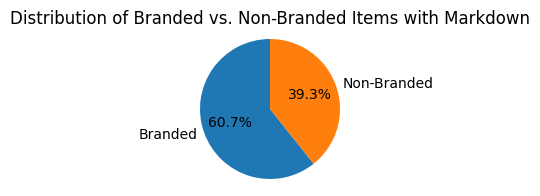

In [475]:
categories = ['Branded', 'Non-Branded']
counts = [branded_markdown_count, non_branded_markdown_count]
plt.figure(figsize=(4, 2))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e'])
plt.axis('equal')
plt.title('Distribution of Branded vs. Non-Branded Items with Markdown')
plt.show()

In [476]:
def plot_analysis(df, variable):
  plt.figure(figsize=(16, 6))
  df['Percentage Markdown'].plot(kind='bar', color='coral')
  plt.title('Percentage of Items with Markdown by Vendor')
  plt.xlabel(variable)
  plt.ylabel('Percentage (%)')
  plt.axhline(y=df['Percentage Markdown'].mean(), color='blue', linestyle='--',
            label=f'Average: {df["Percentage Markdown"].mean():.1f}%')
  plt.legend()
  plt.xticks(rotation=45, ha='right')
  plt.grid(axis='y', alpha=0.7)
  plt.tight_layout()
  plt.show()

### **Vendor Specific Analysis -**

In [477]:
vendor_markdown_data = df.groupby(['Vendor', 'Has_Markdown']).size().unstack(fill_value=0)

vendor_markdown_data.columns = ['No Markdown', 'Has Markdown']
vendor_markdown_data['Total'] = vendor_markdown_data.sum(axis=1)
vendor_markdown_data['Percentage Markdown'] = (vendor_markdown_data['Has Markdown'] * 100) / vendor_markdown_data['Total']
vendor_markdown_data = vendor_markdown_data.sort_values('Percentage Markdown', ascending=False)

vendor_markdown_data

,No Markdown,Has Markdown,Total,Percentage Markdown
Vendor,,,,
1,0,5,5,100.000000
84,0,8,8,100.000000
5,0,4,4,100.000000
42,0,3,3,100.000000
99,0,43,43,100.000000
...,...,...,...,...
70,44,10,54,18.518519
36,1,0,1,0.000000
21,5,0,5,0.000000


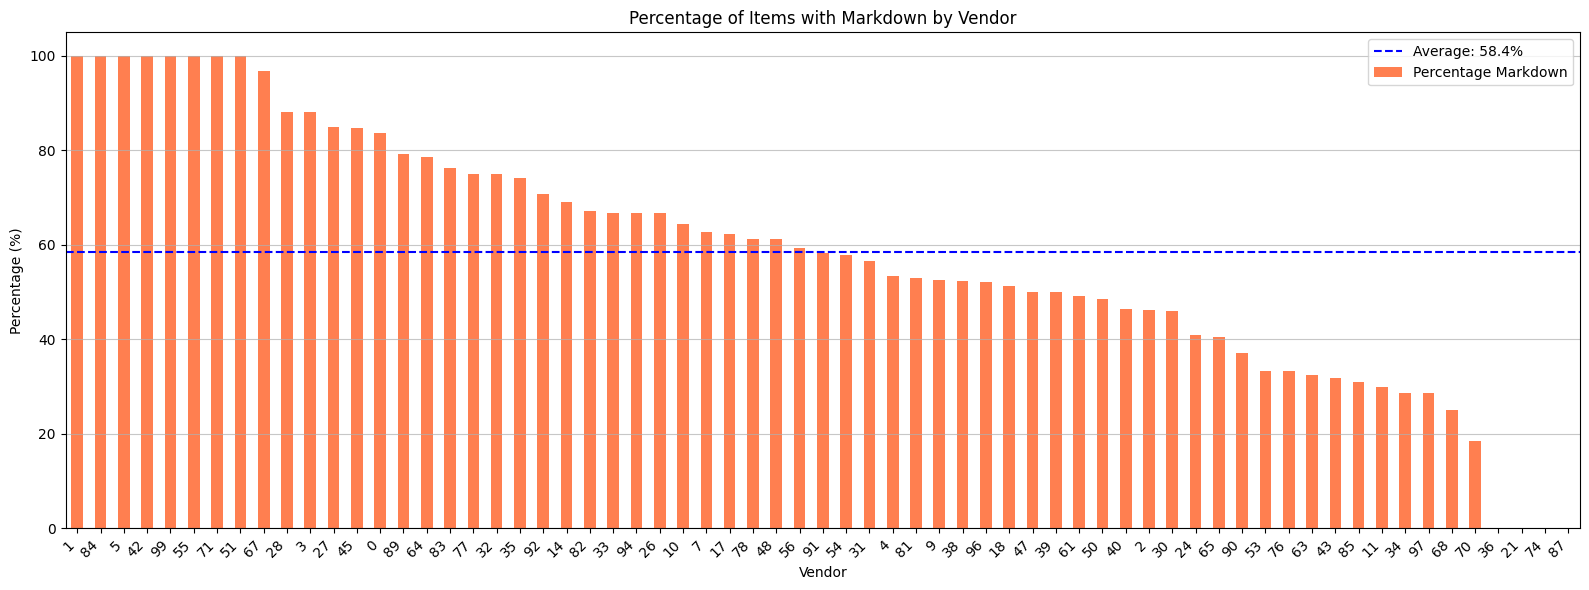

In [478]:
plot_analysis(vendor_markdown_data, variable='Vendor')

In [479]:
df['% LC comp. b M'] = (df['Week of Markdown'] / df['Total Lifecycle'])
df['% Inv. sold by W3'] = (df['Sales by Week 3'] / (df['Sales'] + df['Units Left']))
df['% Inv. sold'] = (df['Sales'] / (df['Sales'] + df['Units Left']))
df['Price Markup'] = (df['Initial Price'] / df['Cost'])
df["Sales Percentage"] = (df["Sales Amount"] / df["Sales Amount"].sum()) * 100
df['Markdown'] = (df['Markdown'] / 100)
df

,ID,Branded?,Buyer,Vendor,Cost,Initial Price,Markdown,Week Available,Week of Markdown,Sales by Week 3,...,Units Left,Profit - 1st Ticket Price,Sunk Cost,Has_Markdown,Revenue Left,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage
0,1,1,1005,61,84.925,197.50,0.5,6,17.0,2,...,4,112.575,339.700,True,834.0000,0.653846,0.125000,0.750000,2.325581,0.001811
1,2,0,1011,83,144.375,460.00,NaN,46,NaN,5,...,3,315.625,433.125,False,-90.0000,NaN,0.312500,0.812500,3.186147,0.007158
2,3,1,1011,85,67.825,172.50,NaN,46,NaN,7,...,2,104.675,135.650,False,50.0000,NaN,0.388889,0.888889,2.543310,0.003196
3,4,1,1011,85,63.575,172.50,NaN,41,NaN,5,...,3,108.925,190.725,False,47.5000,NaN,0.277778,0.833333,2.713331,0.002995
4,5,1,1005,89,92.400,220.00,0.5,7,12.0,3,...,3,127.600,277.200,True,1484.0000,0.480000,0.150000,0.850000,2.380952,0.002660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,4076,1,1002,10,34.375,62.45,0.5,24,15.0,54,...,4144,28.075,142450.000,True,75111.7375,0.714286,0.007186,0.448570,1.816727,0.159677
4076,4077,1,1002,45,31.875,62.45,0.5,4,24.0,2650,...,1915,30.575,61040.625,True,90514.8000,0.857143,0.324000,0.765864,1.959216,0.354563
4077,4078,0,1003,18,11.000,24.95,NaN,2,NaN,960,...,1856,13.950,20416.000,False,-9.0818,NaN,0.109265,0.788755,2.268182,0.203905
4078,4079,0,1003,18,11.000,24.95,NaN,10,NaN,1674,...,3738,13.950,41118.000,False,-0.4990,NaN,0.129999,0.709715,2.268182,0.268888


## **Correlation Analysis -**

In [480]:
correlation_data = df.drop(columns=['ID', 'Buyer', 'Vendor', 'Cost', 'Initial Price', 'Week of Markdown', 'Week Available', 'Sunk Cost', 'Has_Markdown', 'Units Left',
                                    'Revenue Left', 'Profit - 1st Ticket Price', 'Total Lifecycle', 'Sales', 'Sales by Week 3', 'Sales Amount'])
correlation_data = correlation_data[correlation_data['Markdown'].notna()]
correlation_data

,Branded?,Markdown,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage
0,1,0.5,0.653846,0.125000,0.750000,2.325581,0.001811
4,1,0.5,0.480000,0.150000,0.850000,2.380952,0.002660
13,0,0.5,0.666667,0.208333,0.750000,2.500000,0.002223
14,0,0.5,0.571429,0.375000,0.833333,2.500000,0.002105
27,1,0.5,0.590909,0.433333,0.933333,2.250000,0.002408
...,...,...,...,...,...,...,...
4071,1,0.5,0.857143,0.363573,0.859583,1.959216,0.347544
4072,1,0.5,0.750000,0.096122,0.781529,1.959216,0.258198
4073,1,0.5,0.857143,0.362828,0.857619,1.959216,0.349469
4075,1,0.5,0.714286,0.007186,0.448570,1.816727,0.159677


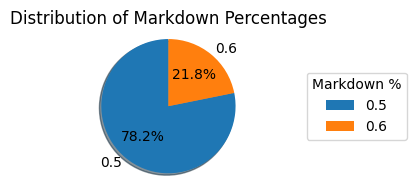

In [481]:
markdown_counts = correlation_data['Markdown'].value_counts().sort_index()

plt.figure(figsize=(4, 2))
plt.pie(markdown_counts, labels=markdown_counts.index,autopct='%1.1f%%',
        startangle=90,shadow=True)
plt.axis('equal')
plt.title('Distribution of Markdown Percentages')
plt.legend(title='Markdown %', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()

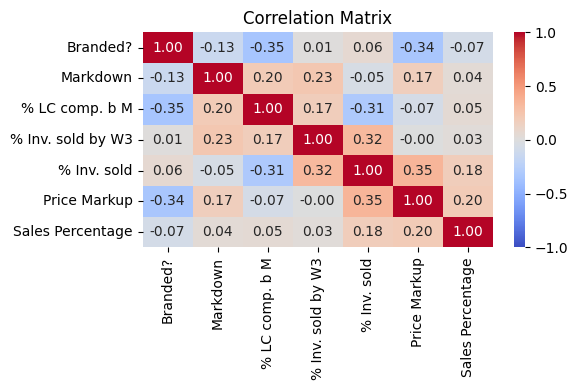

In [482]:
correlation_matrix = correlation_data.corr()

def plot_correlation(matrix):
  plt.figure(figsize=(6, 4))
  sns.heatmap(matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
  plt.title('Correlation Matrix')
  plt.tight_layout()
  plt.show()

plot_correlation(matrix=correlation_matrix)

In [483]:
correlation_data

,Branded?,Markdown,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage
0,1,0.5,0.653846,0.125000,0.750000,2.325581,0.001811
4,1,0.5,0.480000,0.150000,0.850000,2.380952,0.002660
13,0,0.5,0.666667,0.208333,0.750000,2.500000,0.002223
14,0,0.5,0.571429,0.375000,0.833333,2.500000,0.002105
27,1,0.5,0.590909,0.433333,0.933333,2.250000,0.002408
...,...,...,...,...,...,...,...
4071,1,0.5,0.857143,0.363573,0.859583,1.959216,0.347544
4072,1,0.5,0.750000,0.096122,0.781529,1.959216,0.258198
4073,1,0.5,0.857143,0.362828,0.857619,1.959216,0.349469
4075,1,0.5,0.714286,0.007186,0.448570,1.816727,0.159677


In [484]:
numerical_cols = correlation_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
data_for_clustering = correlation_data[numerical_cols].copy()

# Handling missing values (if any)
data_for_clustering = data_for_clustering.fillna(data_for_clustering.mean())

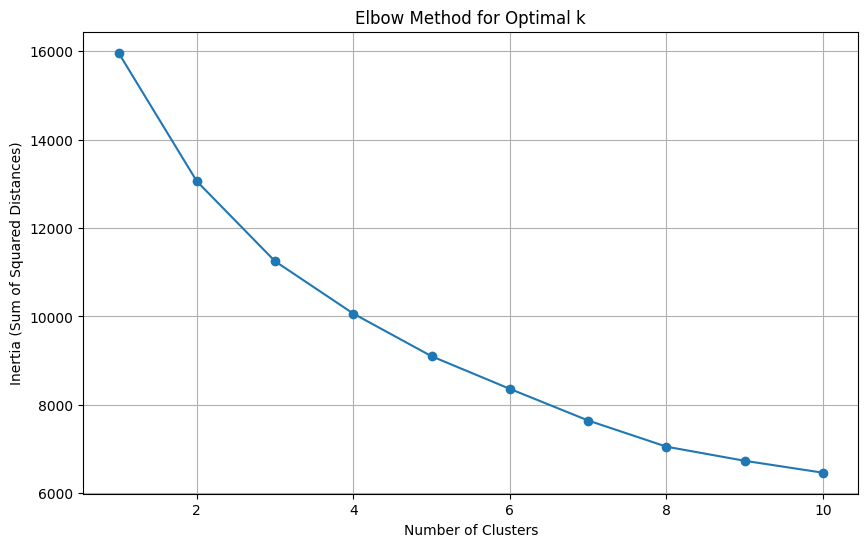

In [485]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Running the Elbow Method chart - getting number of PCs
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

## **3 Clusters -**

In [486]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k)
cluster_labels = kmeans.fit_predict(scaled_data)

correlation_data['Cluster'] = cluster_labels
cluster_summary = correlation_data.groupby('Cluster').mean()

## **Principal Component Analysis with 2 components -**

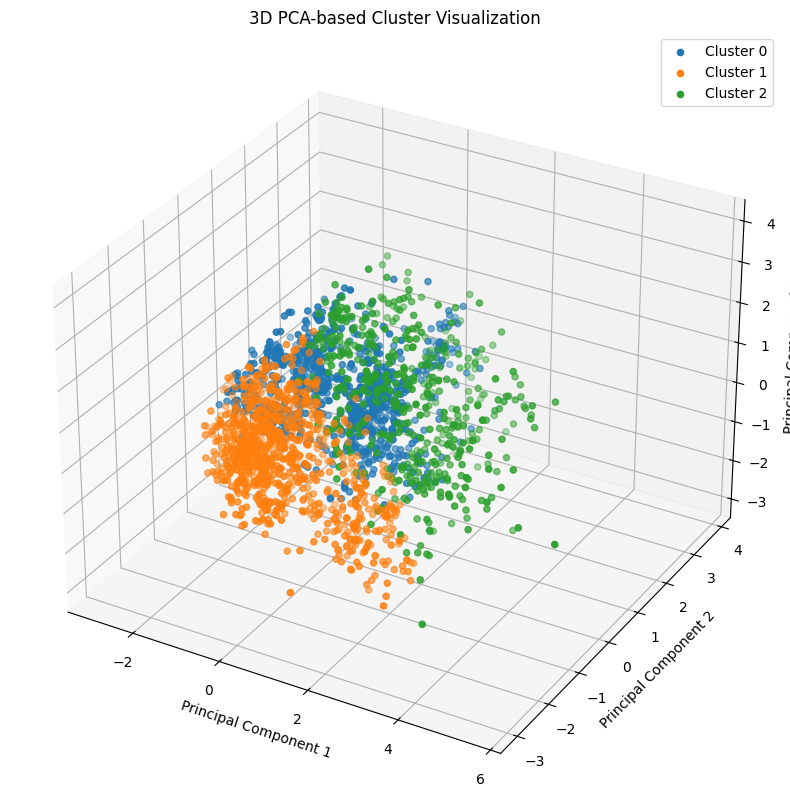

In [487]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = cluster_labels
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(optimal_k):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

ax.set_title('3D PCA-based Cluster Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [488]:
clustering_data = correlation_data.copy()
clustering_data

,Branded?,Markdown,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage,Cluster
0,1,0.5,0.653846,0.125000,0.750000,2.325581,0.001811,0
4,1,0.5,0.480000,0.150000,0.850000,2.380952,0.002660,1
13,0,0.5,0.666667,0.208333,0.750000,2.500000,0.002223,0
14,0,0.5,0.571429,0.375000,0.833333,2.500000,0.002105,0
27,1,0.5,0.590909,0.433333,0.933333,2.250000,0.002408,1
...,...,...,...,...,...,...,...,...
4071,1,0.5,0.857143,0.363573,0.859583,1.959216,0.347544,2
4072,1,0.5,0.750000,0.096122,0.781529,1.959216,0.258198,2
4073,1,0.5,0.857143,0.362828,0.857619,1.959216,0.349469,2
4075,1,0.5,0.714286,0.007186,0.448570,1.816727,0.159677,0


In [489]:
cluster_counts = clustering_data['Cluster'].value_counts().sort_index()
cluster_summary['Count'] = cluster_counts
cluster_summary

,Branded?,Markdown,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage,Count
Cluster,,,,,,,,
0,0.467933,0.514252,0.612810,0.128101,0.575244,2.435697,0.018765,842
1,0.798953,0.501780,0.365659,0.150629,0.863449,2.723666,0.025797,955
2,0.471074,0.574587,0.598112,0.311119,0.836296,2.886269,0.035092,484


In [492]:
# Deviations from overall average
overall_means = clustering_data.loc[:, clustering_data.columns != 'Cluster'].mean()

# z-scores for each metric in each cluster
z_scores = pd.DataFrame()
for cluster in cluster_summary.index:
    cluster_values = cluster_summary.loc[cluster, :]
    cluster_z = (cluster_values[:-1] - overall_means) / overall_means.std()
    z_scores[f'Cluster {cluster}'] = cluster_z

print("\nZ-scores (deviations from overall mean):")
z_scores.T


Z-scores (deviations from overall mean):


,Branded?,Markdown,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage
Cluster 0,-0.158983,-0.008655,0.121695,-0.055104,-0.200996,-0.246794,-0.007316
Cluster 1,0.218928,-0.022893,-0.160467,-0.029384,0.128035,0.081968,0.000711
Cluster 2,-0.155397,0.060227,0.104915,0.153840,0.097036,0.267605,0.011323


<Figure size 400x200 with 0 Axes>

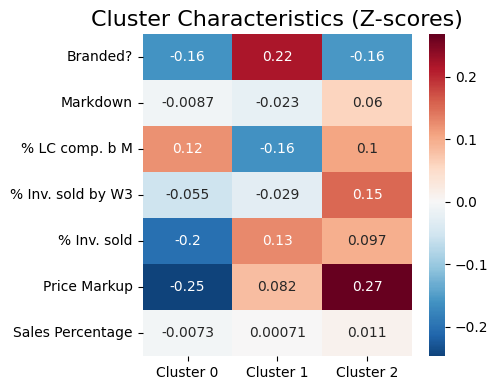

<Figure size 400x200 with 0 Axes>

In [529]:
# Differences between clusters
plt.figure(figsize=(5, 4))
sns.heatmap(z_scores, annot=True, cmap='RdBu_r', center=0)
plt.title('Cluster Characteristics (Z-scores)', fontsize=16)
plt.tight_layout()
plt.savefig('cluster_heatmap.png')

key_metrics = ['Price Markup', 'Sales Percentage', '% Inv. sold', 'Branded?', 'Markdown',
               '% LC comp. b M','% Inv. sold by W3']
plt.figure(figsize=(4, 2))

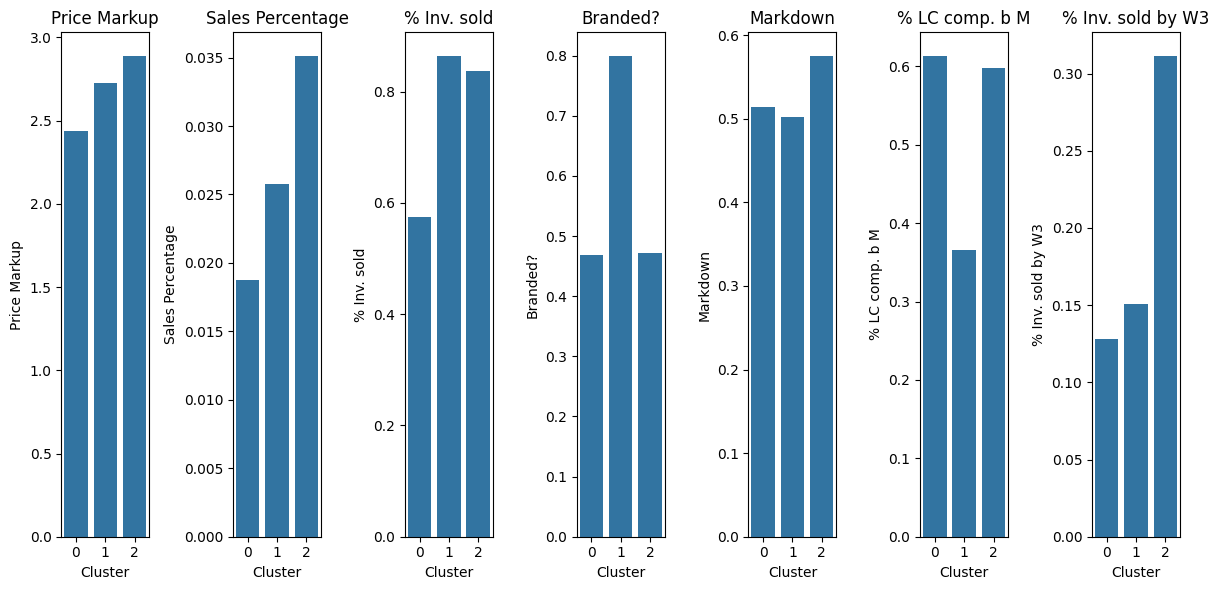

In [533]:
plt.figure(figsize=(12, 6))

for i, metric in enumerate(key_metrics):
    plt.subplot(1, 7, i+1)
    sns.barplot(x=cluster_summary.index, y=cluster_summary[metric])
    plt.title(f'{metric}')
    plt.ylabel(metric)
    plt.xlabel('Cluster')

plt.tight_layout()

Initial Pricing is similar for all.
### **Cluster 0 -**
* Incoming revenue is lower.
* 50% inventory is sold at the end - markdown should be earlier.
* More than 60% Lifecycle is completed before the markdown and inventory sold by week 3 is less than 15%. Hence, the markdown should definitely be earlier otherwise the product will be salvaged.

### **Cluster 2 -**
* Incoming revenue is high
* 80%+ inventory is sold at the end - markdown should be later.

* About 60% of product lifecycle is completed before the markdown. Even after this, 80%+ inventory is sold eventually. Thus, the markdown is effective. Seeing that 30% of inventory is sold by Week 3, the markdown can be delayed.